In [600]:
import numpy as np
import numpy.ma as ma
from astropy.table import Table, join
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import scipy
from astropy.time import Time
import pandas as pd
import re
import seaborn as sns
import datetime
from datetime import datetime
from datetime import timedelta
from math import e
from math import pi
from math import sqrt
from astropy.table import Column
from scipy.optimize import curve_fit
import scipy.optimize as opt
import statsmodels.api as sm

In [601]:
classes=Table.read('lgcs-m33-v2_classes-Copy1.fits')
print("Classes: ", classes.colnames)
subjects=Table.read('lgcs-m33-v2_subjects-wmeta-Copy1.fits')
print("Subjects: ",subjects.colnames)
markings=Table.read('lgcs-m33-v2_markings-Copy1.fits')
print("Markings: ",markings.colnames)
objects=Table.read('f2_napcan_gridbest.fits')
print("Objects: ", objects.colnames)
marks_for_objects=Table.read('f2_cdata-Copy1.fits')
print("Marks_for_objects:", marks_for_objects.colnames)
Final_Table=Table.read('Final_Table.fits')
print("Final_Table:", Final_Table.colnames)
Syns=Table.read('synclst_lgcs-m33-Copy1.fits')
print("Syns:", Syns.colnames)
gb_si=Table.read('Syntetic_table.fits')
print("Synthetic_table:", gb_si.colnames)

Classes:  ['classification_id', 'user_name', 'user_id', 'user_ip', 'workflow_id', 'workflow_version', 'created_at', 'subject_ids', 'n_markings']
Subjects:  ['SUBJECT_ID', 'PROJECT_ID', 'WORKFLOW_ID', 'SUBJECT_SET_ID', 'SUBIMG', 'BRICK', 'FIELD', 'IMG', 'TOOTH', 'SYNTHETIC', 'SYNFLD', 'CLASSIFICATION_COUNT']
Markings:  ['classification_id', 'user_name', 'user_id', 'subject_ids', 'tool', 'tool_label', 'x', 'y', 'r', 'frame']
Objects:  ['ID', 'SUBJECT_ID', 'CLASSIFICATION_COUNT', 'NEWCLSTFRAC', 'E_NEWCLSTFRAC', 'NEWCLASSCOUNT', 'TOT_D_WEIGHT', 'TOT_NOND_WEIGHT']
Marks_for_objects: ['CLASSIFICATION_ID', 'USER_NAME', 'USER_ID', 'SUBJECT_IDS', 'TOOL', 'TOOL_LABEL', 'X', 'Y', 'R', 'FRAME', 'CANID', 'CANTYPE']
Final_Table: ['Users', 'Num_of_Class', 'Num_of_Im_w/GC_Viewed', 'Total_GC_Viewed', 'Total_GC_Found', 'Percent_Accuracy', 'Average_CFRAC']
Syns: ['SYNID', 'SUBIMG', 'BRICK', 'FIELD', 'IMG', 'NMS', 'NRGB', 'SYN_NUM', 'SYN_FILENAME', 'LOGAGE', 'MASSIN', 'MASSOUT', 'F475TOT', 'F814TOT', 'RCO

In [647]:
cat=Table.read('M33_catalog_with_Quick_BestFit_CMD_Estimates.fits')

In [602]:
high_av_ind=np.where(gb_si['AV'] > 1.5)
gb_si.remove_rows([high_av_ind])
bye_high_av=gb_si

f=np.where(bye_high_av['WEIGHTED_DETECTED_.674']==True)
nf=np.where(bye_high_av['WEIGHTED_DETECTED_.674']==False)

ND=bye_high_av[nf]
D=bye_high_av[f]

/Users/Tobin/opt/anaconda3/lib/python3.7/site-packages/astropy/table/table.py:2287: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  keep_mask[row_specifier] = False


This NMS completeness is really something that we want to look at for the CMF, so I'm going to cut the age range down to 7.0 < Age < 8.5

I am also going to trim the exrememe NMS outliers (the 2 sigma outliers)

2.5371514154636023 3.4906158912740644


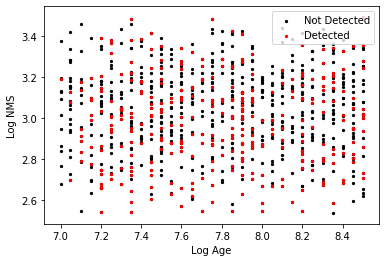

Text(0.5, 0, 'Log NMS')

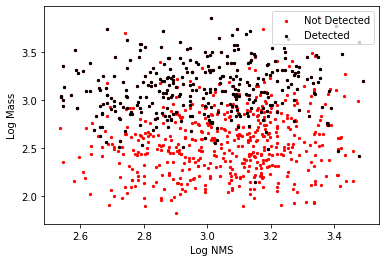

In [604]:
cut_syns1=gb_si[np.where((gb_si['LOGAGE'] >= 7.0) & (gb_si['LOGAGE'] <= 8.5))]

low2s_nms=np.percentile(np.log10(cut_syns1['NMS']), 2.5)
high2s_nms=np.percentile(np.log10(cut_syns1['NMS']), 97.5)

print(low3s_nms, high3s_nms)

cut_syns=cut_syns1[np.where((np.log10(cut_syns1['NMS']) > low2s_nms) &(np.log10(cut_syns1['NMS']) < high2s_nms))]

plt.scatter(cut_syns['LOGAGE'], np.log10(cut_syns['NMS']), color='k', s=5, label='Not Detected')
plt.scatter(cut_syns[np.where(cut_syns['WEIGHTED_DETECTED_.674']==True)]['LOGAGE'], 
            np.log10(cut_syns[np.where(cut_syns['WEIGHTED_DETECTED_.674']==True)]['NMS']), color='r', s=5, label='Detected')
plt.legend()
plt.xlabel('Log Age')
plt.ylabel('Log NMS')
plt.show()

plt.scatter(np.log10(cut_syns['NMS']), np.log10(cut_syns['MASSOUT']), color='r', s=5, label='Not Detected')
plt.scatter(np.log10(cut_syns[np.where(cut_syns['WEIGHTED_DETECTED_.674']==True)]['NMS']), 
            np.log10(cut_syns[np.where(cut_syns['WEIGHTED_DETECTED_.674']==True)]['MASSOUT']), color='k', s=5, label='Detected')
plt.legend()
plt.ylabel('Log Mass')
plt.xlabel('Log NMS')

In [605]:
boundary1=(np.log10(cut_syns.group_by('NMS')[int(len(cut_syns)/3)]['NMS']))
boundary2=(np.log10(cut_syns.group_by('NMS')[int(len(cut_syns)/3)*2]['NMS']))
#boundary3=(np.log10(cut_syns.group_by('NMS')[int(len(cut_syns)/4)*3]['NMS']))

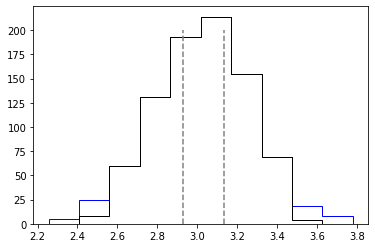

In [606]:
i,b,_=plt.hist(np.log10(cut_syns1['NMS']), histtype='step', color='b')

plt.hist(np.log10(cut_syns['NMS']), histtype='step', color='k', bins=b)
plt.vlines(x=boundary1, ymin=0, ymax=200, linestyles='--', color='gray')
plt.vlines(x=boundary2, ymin=0, ymax=200, linestyles='--', color='gray')
#plt.vlines(x=boundary3, ymin=0, ymax=200, linestyles='--', color='gray')

In [607]:
#If I split this up into 4 equal sized NMS bins

In [608]:
#Splitting up the Syntetics by NMS

b1_nms=cut_syns[np.where(np.log10(cut_syns['NMS']) <= boundary1)]
b1_nms_D=b1_nms[np.where(b1_nms['WEIGHTED_DETECTED_.674']==True)]

b2_nms=cut_syns[np.where((np.log10(cut_syns['NMS']) > boundary1) & (np.log10(cut_syns['NMS']) <= boundary2))]
b2_nms_D=b2_nms[np.where(b2_nms['WEIGHTED_DETECTED_.674']==True)]

b3_nms=cut_syns[np.where((np.log10(cut_syns['NMS']) > boundary2))] #& (np.log10(cut_syns['NMS']) <= boundary3))]
b3_nms_D=b3_nms[np.where(b3_nms['WEIGHTED_DETECTED_.674']==True)]

#b4_nms=cut_syns[np.where(np.log10(cut_syns['NMS']) >= boundary3)]
#b4_nms_D=b4_nms[np.where(b4_nms['WEIGHTED_DETECTED_.674']==True)]

Text(0, 0.5, 'log Mass')

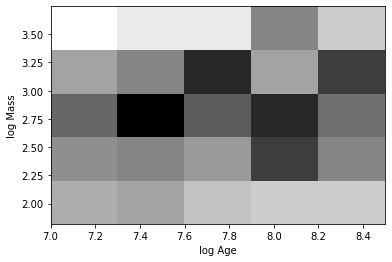

In [609]:
bin_size=5

x,xedges_1,yedges_1,im=plt.hist2d(b1_nms['LOGAGE'], np.log10(b1_nms['MASSOUT']), bins=bin_size, cmap='gray_r', label='Synthetic Clusters')
plt.xlabel('log Age')
plt.ylabel('log Mass')

In [610]:
import statsmodels as sm

/Users/Tobin/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in true_divide
  
/Users/Tobin/opt/anaconda3/lib/python3.7/site-packages/statsmodels/stats/proportion.py:86: RuntimeWarning: invalid value encountered in double_scalars
  q_ = count * 1. / nobs


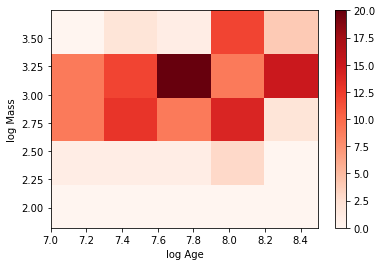

In [611]:
f,_,_,_=plt.hist2d(b1_nms_D['LOGAGE'], np.log10(b1_nms_D['MASSOUT']), bins=[xedges_1, yedges_1], cmap='Reds', label='Synthetic Clusters')
plt.colorbar()
plt.xlabel('log Age')
plt.ylabel('log Mass')

com_1=np.array(f/x)

err_1=np.zeros((len(f), len(f)))
for i in range(len(f)):
    for j in range(len(f)):
        err_1[i][j]=(sm.stats.proportion.proportion_confint(f[i][j], x[i][j], alpha=.34, method='agresti_coull')[1]-sm.stats.proportion.proportion_confint(f[i][j], x[i][j], alpha=.34, method='agresti_coull')[0])/2


where_are_NaNs = np.isnan(com_1)
where_are_inf = np.isinf(com_1)
com_1[where_are_NaNs] = -.1
com_1[where_are_inf] = -.1
err_1[where_are_NaNs]= -.1
err_1[where_are_inf]= -.1

Text(0, 0.5, 'log Mass')

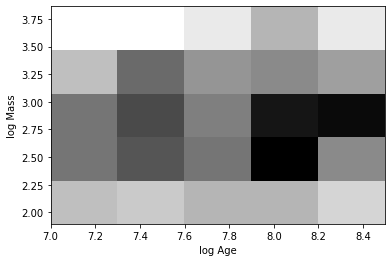

In [612]:
x,xedges_2,yedges_2,im=plt.hist2d(b2_nms['LOGAGE'], np.log10(b2_nms['MASSOUT']), bins=bin_size, cmap='gray_r', label='Synthetic Clusters')
plt.xlabel('log Age')
plt.ylabel('log Mass')

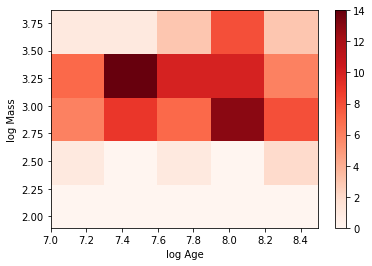

In [613]:
f,_,_,_=plt.hist2d(b2_nms_D['LOGAGE'], np.log10(b2_nms_D['MASSOUT']), bins=[xedges_2, yedges_2], cmap='Reds', label='Synthetic Clusters')
plt.colorbar()
plt.xlabel('log Age')
plt.ylabel('log Mass')

com_2=np.array(f/x)

err_2=np.zeros((len(f), len(f)))
for i in range(len(f)):
    for j in range(len(f)):
        err_2[i][j]=(sm.stats.proportion.proportion_confint(f[i][j], x[i][j], alpha=.34, method='agresti_coull')[1]-sm.stats.proportion.proportion_confint(f[i][j], x[i][j], alpha=.34, method='agresti_coull')[0])/2


where_are_NaNs = np.isnan(com_2)
where_are_inf = np.isinf(com_2)
com_2[where_are_NaNs] = -.1
com_2[where_are_inf] = -.1
err_2[where_are_NaNs]= -.1
err_2[where_are_inf]= -.1

Text(0, 0.5, 'log Mass')

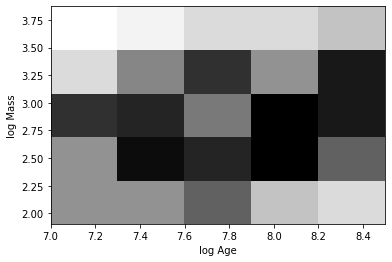

In [614]:
x,xedges_3,yedges_3,im=plt.hist2d(b3_nms['LOGAGE'], np.log10(b3_nms['MASSOUT']), bins=bin_size, cmap='gray_r', label='Synthetic Clusters')
plt.xlabel('log Age')
plt.ylabel('log Mass')

/Users/Tobin/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in true_divide
  


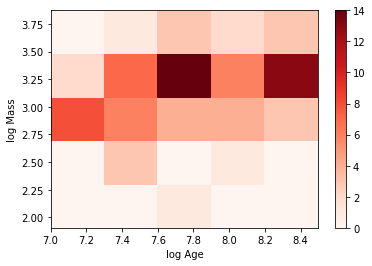

In [615]:
f,_,_,_=plt.hist2d(b3_nms_D['LOGAGE'], np.log10(b3_nms_D['MASSOUT']), bins=[xedges_3, yedges_3], cmap='Reds', label='Synthetic Clusters')
plt.colorbar()
plt.xlabel('log Age')
plt.ylabel('log Mass')

com_3=np.array(f/x)

err_3=np.zeros((len(f), len(f)))
for i in range(len(f)):
    for j in range(len(f)):
        err_3[i][j]=(sm.stats.proportion.proportion_confint(f[i][j], x[i][j], alpha=.34, method='agresti_coull')[1]-sm.stats.proportion.proportion_confint(f[i][j], x[i][j], alpha=.34, method='agresti_coull')[0])/2


where_are_NaNs = np.isnan(com_3)
where_are_inf = np.isinf(com_3)
com_3[where_are_NaNs] = -.1
com_3[where_are_inf] = -.1
err_3[where_are_NaNs]= -.1
err_3[where_are_inf]= -.1

In [616]:
#x,xedges_4,yedges_4,im=plt.hist2d(b4_nms['LOGAGE'], np.log10(b4_nms['MASSOUT']), bins=bin_size, cmap='gray_r', label='Synthetic Clusters')
#plt.xlabel('log Age')
#plt.ylabel('log Mass')

In [617]:
#f,_,_,_=plt.hist2d(b4_nms_D['LOGAGE'], np.log10(b4_nms_D['MASSOUT']), bins=[xedges_4, yedges_4], cmap='Reds', label='Synthetic Clusters')
#plt.colorbar()
#plt.xlabel('log Age')
#plt.ylabel('log Mass')

#com_4=np.array(f/x)

#err_4=np.zeros((len(f), len(f)))
#for i in range(len(f)):
#    for j in range(len(f)):
#        err_4[i][j]=(sm.stats.proportion.proportion_confint(f[i][j], x[i][j], alpha=.34, method='agresti_coull')[1]-sm.stats.proportion.proportion_confint(f[i][j], x[i][j], alpha=.34, method='agresti_coull')[0])/2


#where_are_NaNs = np.isnan(com_4)
#where_are_inf = np.isinf(com_4)
#com_4[where_are_NaNs] = -.1
#com_4[where_are_inf] = -.1
#err_4[where_are_NaNs]= -.1
#err_4[where_are_inf]= -.1

In [618]:
#Needed Functions

def gen_logistic_func(x, x0, k):
    #Current configuration: 2-parameter model, Q=nu=1
    
    A=0
    B=1
    C=1
    Q=1
    nu=1

    return A + ((B-A) / ((C + Q*np.exp(-k*(x-x0)))**(1/nu)))

def forced_slope_gen_logistic_func(x, x0, k):
    #Current configuration: 2-parameter model, Q=nu=1
    
    #.674_thresh_k=6.3665
    #.568_thresh_K=5.83
    
    A=0
    B=1
    C=1
    Q=1
    nu=1
    

    return A + ((B-A) / ((C + Q*np.exp(-k*(x-x0)))**(1/nu)))

def linear_poly1(x,a,b):
    return a*x+b
    

    #popt_50fit, pcov_50fit= curve_fit(linear_poly1, x,y)

def completeness(linear_poly1, x, y):
    xs = np.linspace(18.9, 20.1, 100)
    popt_50fit, pcov_50fit = curve_fit(linear_poly1, x, y)
    line = np.poly1d(popt_50fit)

    return ((.5-popt_50fit[1])/(popt_50fit[0]))

def exponential(tau,a,b,c):
    y= a*np.exp(b*(tau-6.71))+c
    return y

def new_log_func(x, age, a, b, c):
    
    A=0
    B=1
    C=1
    Q=1
    nu=1
    k=6.4307
    
    x0 = exponential(age, a, b, c)

    return A + ((B-A) / ((C + Q*np.exp(-k*(x-x0)))**(1/nu)))

def get_model(masses, ages, a, b, c):

    maybe=np.zeros((len(masses), len(masses) ))

    for i in range((len(masses))):
        maybe[i]= new_log_func(masses, ages[i], a, b, c)
    
    return maybe

def lnlike(theta, masses, ages, com, err):
    a, b, c = theta
    
    model=get_model(masses, ages, a, b, c)

    
    fc_com=com[:-1]
    fc_model=model[:-1].astype('float32')
    fc_err=err[:-1]
    
    where_data = np.where(fc_com != -.1)
    
    use_com=fc_com[where_data]
    use_model=fc_model[where_data]
    use_err=fc_err[where_data]
    
    chi2= ((use_com-use_model)**2) / (use_err**2)

    return np.sum( -chi2 - 2)

In [619]:
def get_com_mod(bin1, gb_si, D, yedges, k): 
    syn_ind=np.where((gb_si['LOGAGE'] >= bin1[0]) & (gb_si['LOGAGE'] < bin1[2]))
    found_ind=np.where((D['LOGAGE'] >= bin1[0]) & (D['LOGAGE'] < bin1[2]))
    clsts=gb_si[syn_ind]
    found=D[found_ind]

    plt.ioff()
    fig1=plt.figure()
    ys,bins,_=plt.hist(np.log10(clsts['MASSIN']), histtype='step', color='r', bins=yedges, label='Total')
    h,x,_=plt.hist(np.log10(found['MASSIN']), histtype='step', color='k', bins=yedges, label='Detected')
    plt.xlabel('Log Mass')
    plt.ylabel('N Synthetic Clusters')
    plt.legend()
    plt.close(fig1)
    
    tot=ys
    com=h/tot

    #Setting error for places with no found to be 1 in error
    where_zeros=np.where(h == 0)
    h[where_zeros] = 1

    err=np.zeros((len(h)))
    for i in range(len(h)):
        err[i]=(sm.stats.proportion.proportion_confint(h[i], tot[i], alpha=.34, method='agresti_coull')[1]-sm.stats.proportion.proportion_confint(h[i], tot[i], alpha=.34, method='agresti_coull')[0])/2

    where_are_NaNs = np.isnan(com)
    where_data = [~np.isnan(com)]

    #Only try and fit bins where I have data
    use_com=com[where_data]
    use_edges=yedges[:-1][where_data]
    use_err=err[where_data]

    initial_guess=[np.median(use_edges), 7]
    initial_guess_f=[np.median(use_edges), k]

    (x0_, k_),_ = opt.curve_fit(gen_logistic_func, xdata=use_edges, ydata=use_com, sigma=use_err, p0=initial_guess, maxfev=500000)
    
    lf_fit=gen_logistic_func(use_edges, x0=x0_, k=k_)
    
    (fx0_, fk_),_ = opt.curve_fit(forced_slope_gen_logistic_func, xdata=use_edges, ydata=use_com, sigma=use_err, p0=initial_guess_f, maxfev=500000)
    
    
    lf_fit_forced_ss=forced_slope_gen_logistic_func(use_edges, x0=fx0_, k=k)
    
    
    plt.plot(use_edges, use_com, color='k', label='Data')
    eb=plt.errorbar(use_edges, use_com, yerr=use_err, color='k', label='Errors')
    eb[-1][0].set_linestyle('--')
#    plt.plot(use_edges, lf_fit, color='b', label='Fit')
    plt.plot(use_edges, lf_fit_forced_ss, color='g', label='Logistic Function Fit')
    plt.xlabel('Log Mass')
    plt.ylabel('Completeness')
    plt.text(2.2, .65, str('Log age:')+str("{:.2f}".format(bin1[0]))+str(':')+str("{:.2f}".format(bin1[2])) ,bbox={'facecolor':'w'})
    plt.legend()
    plt.ylim(-.1,1.1)
    plt.show()
#    plt.close()
    
        
    ptile=[.50]
    ptile_out = np.interp(ptile, fp=use_edges, xp=lf_fit_forced_ss)
    print(ptile_out)
    
    hi=completeness(linear_poly1, use_edges, use_com)
    print(hi)

    par= [fx0_, k_, ptile_out, hi]
    
    return par

B1: 6.270888463196911
B2: 7.120140035860737
B3: 4.839832471446485


Need 1 sentence in the paper, saying that this changes the 50% complenteness by less than .1 dex, and therefore doesn't "really" matter

In [645]:
kb1=6.270888463196911
kb2=7.120140035860737
kb3=4.839832471446485

/Users/Tobin/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:31: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
/Users/Tobin/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:32: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
/Users/Tobin/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:33: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, w

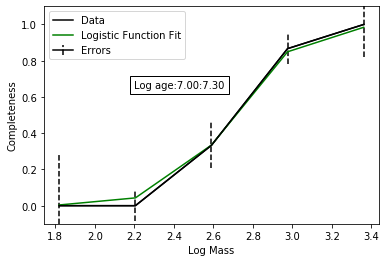

[2.71483459]
2.6716507031829755


/Users/Tobin/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:31: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
/Users/Tobin/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:32: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
/Users/Tobin/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:33: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, w

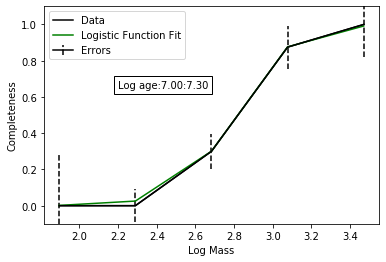

[2.81932206]
2.7720663935525987


/Users/Tobin/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:31: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
/Users/Tobin/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:32: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
/Users/Tobin/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:33: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, w

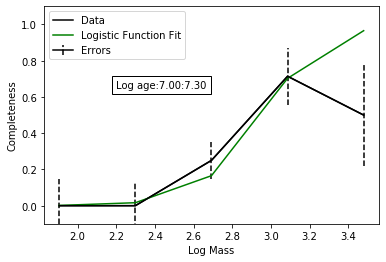

[2.93734177]
3.167731306347783


/Users/Tobin/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:31: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
/Users/Tobin/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:32: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
/Users/Tobin/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:33: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, w

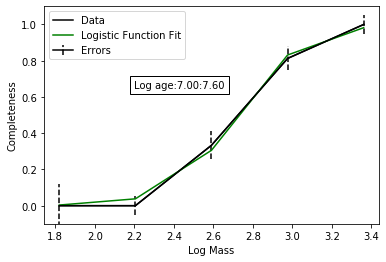

[2.73347241]
2.6880481190105097


/Users/Tobin/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:31: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
/Users/Tobin/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:32: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
/Users/Tobin/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:33: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, w

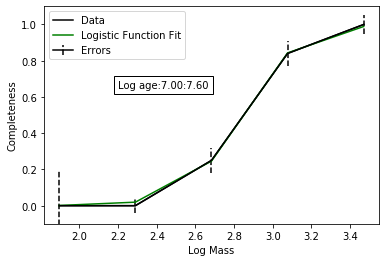

[2.85046702]
2.7967181060137385


/Users/Tobin/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:31: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
/Users/Tobin/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:32: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
/Users/Tobin/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:33: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, w

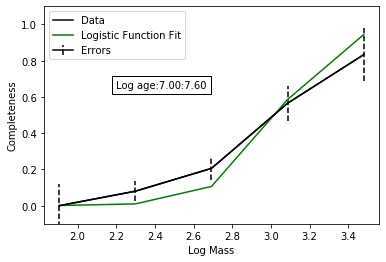

[3.01539401]
2.9906041375306742


/Users/Tobin/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:31: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
/Users/Tobin/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:32: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
/Users/Tobin/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:33: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, w

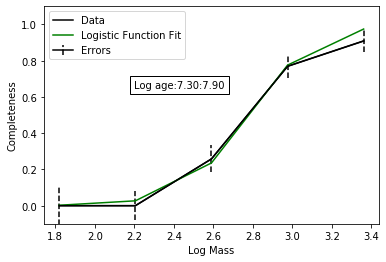

[2.77951889]
2.7588820359809048


/Users/Tobin/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:31: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
/Users/Tobin/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:32: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
/Users/Tobin/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:33: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, w

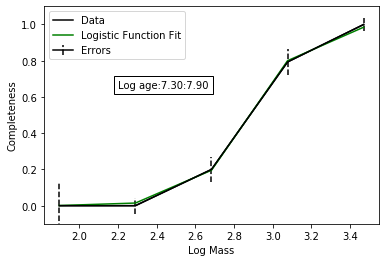

[2.88123362]
2.8259287073765584


/Users/Tobin/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:31: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
/Users/Tobin/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:32: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
/Users/Tobin/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:33: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, w

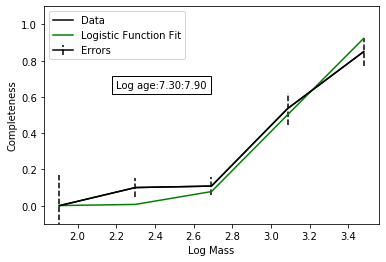

[3.08430817]
3.026236312065894


/Users/Tobin/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:31: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
/Users/Tobin/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:32: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
/Users/Tobin/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:33: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, w

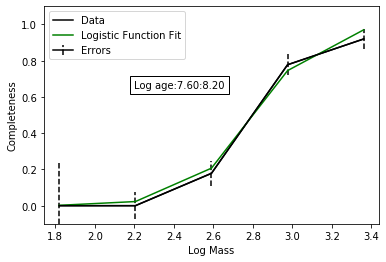

[2.80069306]
2.774611091203096


/Users/Tobin/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:31: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
/Users/Tobin/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:32: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
/Users/Tobin/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:33: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, w

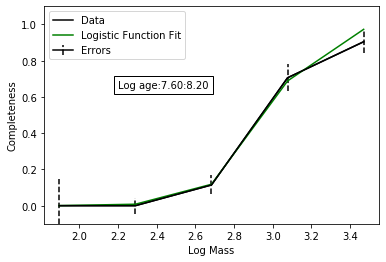

[2.946601]
2.925603402804924


/Users/Tobin/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:31: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
/Users/Tobin/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:32: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
/Users/Tobin/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:33: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, w

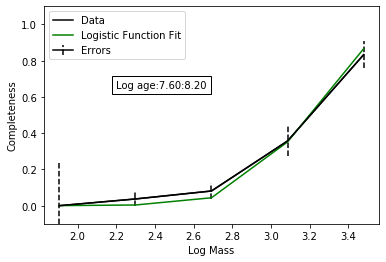

[3.19895426]
3.164193132654053


/Users/Tobin/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:31: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
/Users/Tobin/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:32: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
/Users/Tobin/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:33: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, w

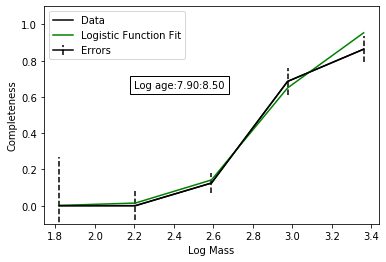

[2.86272138]
2.854716363090684


/Users/Tobin/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:31: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
/Users/Tobin/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:32: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
/Users/Tobin/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:33: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, w

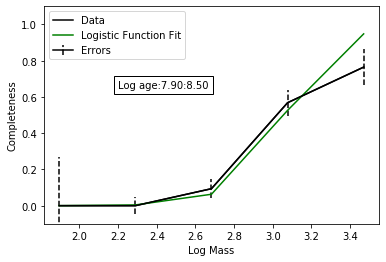

[3.05459736]
3.0858272854743487


/Users/Tobin/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:31: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
/Users/Tobin/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:32: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
/Users/Tobin/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:33: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, w

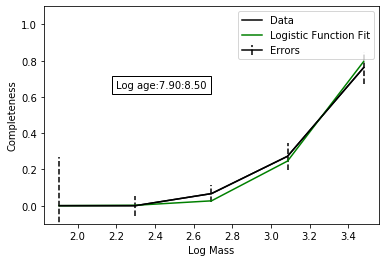

[3.26734745]
3.3049139312547138


/Users/Tobin/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:31: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
/Users/Tobin/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:32: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
/Users/Tobin/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:33: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, w

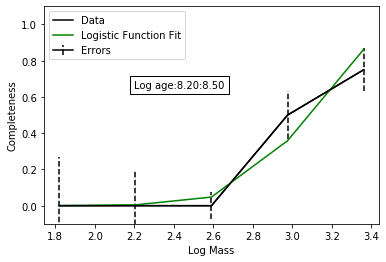

[3.08454551]
3.0727069174159043


/Users/Tobin/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in true_divide
/Users/Tobin/opt/anaconda3/lib/python3.7/site-packages/statsmodels/stats/proportion.py:86: RuntimeWarning: divide by zero encountered in double_scalars
  q_ = count * 1. / nobs
/Users/Tobin/opt/anaconda3/lib/python3.7/site-packages/statsmodels/stats/proportion.py:123: RuntimeWarning: invalid value encountered in sqrt
  std_c = np.sqrt(q_c * (1. - q_c) / nobs_c)
/Users/Tobin/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:31: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
/Users/Tobin/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:32: FutureWarning: Using a non-tuple sequence for multidimensional i

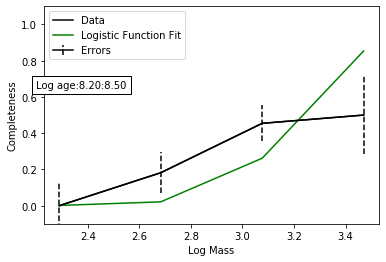

[3.23486428]
3.3591314500921987


/Users/Tobin/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:31: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
/Users/Tobin/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:32: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
/Users/Tobin/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:33: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, w

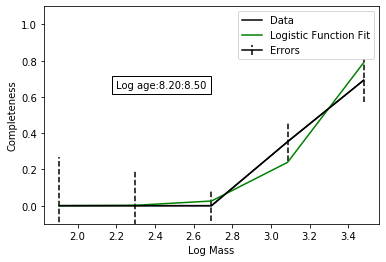

[3.27228711]
3.3510790057992597


In [641]:
b1_nms_fl_fits=np.zeros((len(xedges_1),4))
b2_nms_fl_fits=np.zeros((len(xedges_2),4))
b3_nms_fl_fits=np.zeros((len(xedges_3),4))
#b4_nms_fl_fits=np.zeros((len(xedges_4),4))

bin_try_1=np.zeros((len(xedges_1), 3))
bin_try_1[0]=(xedges_1[0], (xedges_1[0]+xedges_1[1])/2, xedges_1[1])
bin_try_1[bin_size]=(xedges_1[bin_size-1], (xedges_1[bin_size-1]+xedges_1[bin_size])/2,
                   xedges_1[bin_size])

for i in range(1,len(xedges_1)-1):
    bin_try_1[i]=[xedges_1[i-1], xedges_1[i], xedges_1[i+1]]
    
bin_try_2=np.zeros((len(xedges_2), 3))
bin_try_2[0]=(xedges_2[0], (xedges_2[0]+xedges_2[1])/2, xedges_2[1])
bin_try_2[bin_size]=(xedges_2[bin_size-1], (xedges_2[bin_size-1]+xedges_2[bin_size])/2,
                   xedges_2[bin_size])

for i in range(1,len(xedges_2)-1):
    bin_try_2[i]=[xedges_2[i-1], xedges_2[i], xedges_2[i+1]]
    
bin_try_3=np.zeros((len(xedges_3), 3))
bin_try_3[0]=(xedges_2[0], (xedges_3[0]+xedges_3[1])/2, xedges_3[1])
bin_try_3[bin_size]=(xedges_3[bin_size-1], (xedges_3[bin_size-1]+xedges_3[bin_size])/2,
                   xedges_3[bin_size])

for i in range(1,len(xedges_3)-1):
    bin_try_3[i]=[xedges_3[i-1], xedges_3[i], xedges_3[i+1]]
    
#bin_try_4=np.zeros((len(xedges_4), 3))
#bin_try_4[0]=(xedges_4[0], (xedges_4[0]+xedges_4[1])/2, xedges_4[1])
#bin_try_4[bin_size]=(xedges_4[bin_size-1], (xedges_4[bin_size-1]+xedges_4[bin_size])/2,
#                   xedges_4[bin_size])

#for i in range(1,len(xedges_4)-1):
#    bin_try_4[i]=[xedges_4[i-1], xedges_4[i], xedges_4[i+1]]
    
    
for i in range(len(yedges_1)):                                  
    b1_nms_fl_fits[i]= get_com_mod(bin_try_1[i], b1_nms, b1_nms_D, yedges_1, k=kb1)
    b2_nms_fl_fits[i]= get_com_mod(bin_try_2[i], b2_nms, b2_nms_D, yedges_2, k=kb2)
    b3_nms_fl_fits[i]= get_com_mod(bin_try_3[i], b3_nms, b3_nms_D, yedges_3, k=kb3)
#    b4_nms_fl_fits[i]= get_com_mod(bin_try_4[i], b4_nms, b4_nms_D, yedges_4)

b1_nms_bined_fit_array=np.zeros((len(yedges_1)-1, bin_size))
b2_nms_bined_fit_array=np.zeros((len(yedges_2)-1, bin_size))
b3_nms_bined_fit_array=np.zeros((len(yedges_3)-1, bin_size))
#b4_nms_bined_fit_array=np.zeros((len(yedges_4)-1, bin_size))

for i in range((len(yedges_1)-1)):
    b1_nms_bined_fit_array[i]= forced_slope_gen_logistic_func(yedges_1[:-1], x0=b1_nms_fl_fits[i][0], k=kb1)
    b2_nms_bined_fit_array[i]= forced_slope_gen_logistic_func(yedges_2[:-1], x0=b2_nms_fl_fits[i][0], k=kb2)
    b3_nms_bined_fit_array[i]= forced_slope_gen_logistic_func(yedges_3[:-1], x0=b3_nms_fl_fits[i][0], k=kb3)
#    b4_nms_bined_fit_array[i]= forced_slope_gen_logistic_func(yedges_4[:-1], x0=b4_nms_fl_fits[i][0])

#Making Data accessible
lefts_1=[]
mids_1=[]
rights_1=[]
x0s_1=[]
fiftys_1=[]
ks_1=[]
lefts_2=[]
mids_2=[]
rights_2=[]
x0s_2=[]
fiftys_2=[]
ks_2=[]
lefts_3=[]
mids_3=[]
rights_3=[]
x0s_3=[]
fiftys_3=[]
ks_3=[]
lefts_4=[]
mids_4=[]
rights_4=[]
x0s_4=[]
fiftys_4=[]
ks_4=[]

    
for i in range(len(bin_try_1)):
    lefts_1.append(bin_try_1[i][0])
    mids_1.append(bin_try_1[i][1])
    rights_1.append(bin_try_1[i][2])
    lefts_2.append(bin_try_2[i][0])
    mids_2.append(bin_try_2[i][1])
    rights_2.append(bin_try_2[i][2])
    lefts_3.append(bin_try_3[i][0])
    mids_3.append(bin_try_3[i][1])
    rights_3.append(bin_try_3[i][2])
#    lefts_4.append(bin_try_4[i][0])
#    mids_4.append(bin_try_4[i][1])
#    rights_4.append(bin_try_4[i][2])
    
    x0s_1.append(b1_nms_fl_fits[i][0])
    fiftys_1.append(b1_nms_fl_fits[i][2])
    ks_1.append(b1_nms_fl_fits[i][1])
    x0s_2.append(b2_nms_fl_fits[i][0])
    fiftys_2.append(b2_nms_fl_fits[i][2])
    ks_2.append(b2_nms_fl_fits[i][1])
    x0s_3.append(b3_nms_fl_fits[i][0])
    fiftys_3.append(b3_nms_fl_fits[i][2])
    ks_3.append(b3_nms_fl_fits[i][1])
#    x0s_4.append(b4_nms_fl_fits[i][0])
#    fiftys_4.append(b4_nms_fl_fits[i][2])
#    ks_4.append(b4_nms_fl_fits[i][1])

b1_nms_logistic_table=Table((lefts_1[:-1], mids_1[:-1], rights_1[:-1], x0s_1[:-1], ks_1[:-1], fiftys_1[:-1], b1_nms_bined_fit_array),
                       names=('LogAge_Bin_Min', 'LogAge_Bin_Med', 'LogAge_Bin_Max', 'LF_Fit_X0', 'LF_Fit_k', '50%_Comp',
                             'LF_Values'))
b2_nms_logistic_table=Table((lefts_2[:-1], mids_2[:-1], rights_2[:-1], x0s_2[:-1], ks_2[:-1], fiftys_2[:-1], b2_nms_bined_fit_array),
                       names=('LogAge_Bin_Min', 'LogAge_Bin_Med', 'LogAge_Bin_Max', 'LF_Fit_X0', 'LF_Fit_k', '50%_Comp',
                             'LF_Values'))
b3_nms_logistic_table=Table((lefts_3[:-1], mids_3[:-1], rights_3[:-1], x0s_3[:-1], ks_3[:-1], fiftys_3[:-1], b3_nms_bined_fit_array),
                       names=('LogAge_Bin_Min', 'LogAge_Bin_Med', 'LogAge_Bin_Max', 'LF_Fit_X0', 'LF_Fit_k', '50%_Comp',
                             'LF_Values'))
#b4_nms_logistic_table=Table((lefts_4[:-1], mids_4[:-1], rights_4[:-1], x0s_4[:-1], ks_4[:-1], fiftys_4[:-1], b4_nms_bined_fit_array),
#                       names=('LogAge_Bin_Min', 'LogAge_Bin_Med', 'LogAge_Bin_Max', 'LF_Fit_X0', 'LF_Fit_k', '50%_Comp',
#                             'LF_Values'))

In [622]:
print("B1:", np.median(b1_nms_logistic_table['LF_Fit_k'][1:]))
print("B2:", np.median(b2_nms_logistic_table['LF_Fit_k'][1:]))
print("B3:", np.median(b3_nms_logistic_table['LF_Fit_k'][1:]))
#print("B4:", np.median(b4_nms_logistic_table['LF_Fit_k']))


B1: 6.270888463196911
B2: 7.120140035860737
B3: 4.839832471446485


In [623]:
b1_nms_logistic_table

LogAge_Bin_Min,LogAge_Bin_Med,LogAge_Bin_Max,LF_Fit_X0,LF_Fit_k,50%_Comp,LF_Values [5]
float64,float64,float64,float64,float64,float64,float64
7.0,7.1499687194824215,7.299937438964844,2.7006224619180594,7.062944209846241,2.7148345891482717,0.003986926596406852 .. 0.9844154937500457
7.0,7.299937438964844,7.599874877929688,2.7218898191576,6.321340395251336,2.7334724107353034,0.0034908782159544373 .. 0.9822316012891987
7.299937438964844,7.599874877929688,7.899812316894531,2.778431381511969,5.610473297566887,2.7795188925611085,0.002451328589107539 .. 0.9748601495489196
7.599874877929688,7.899812316894531,8.199749755859376,2.805082211445701,6.819437032726463,2.8006930610387637,0.002074838089214371 .. 0.9704224363188493
7.899812316894531,8.199749755859376,8.499687194824219,2.877841268038392,6.220436531142486,2.862721382103743,0.0013157141602313748 .. 0.9541064848366326


In [624]:
b3_nms_logistic_table

LogAge_Bin_Min,LogAge_Bin_Med,LogAge_Bin_Max,LF_Fit_X0,LF_Fit_k,50%_Comp,LF_Values [5]
float64,float64,float64,float64,float64,float64,float64
7.0,7.1499687194824215,7.299937438964844,2.9492129874661166,4.234949789931539,2.9417497594109703,0.006369099080182838 .. 0.9285507396288909
7.0,7.299937438964844,7.599874877929688,3.03072763451664,3.695898834362314,3.0212087294089147,0.00430173849836453 .. 0.8975340249638751
7.299937438964844,7.599874877929688,7.899812316894531,3.0847758929511406,4.643894250636237,3.084489547712385,0.0033148929977389646 .. 0.8708545544190016
7.599874877929688,7.899812316894531,8.199749755859376,3.182606702226278,5.035770692256734,3.1928333031979306,0.002067193074117287 .. 0.8076870994118203
7.899812316894531,8.199749755859376,8.499687194824219,3.2632225285577072,5.079110338771356,3.2658219525627965,0.0014003085888928384 .. 0.7397912580700189


In [625]:
b2_nms_logistic_table

LogAge_Bin_Min,LogAge_Bin_Med,LogAge_Bin_Max,LF_Fit_X0,LF_Fit_k,50%_Comp,LF_Values [5]
float64,float64,float64,float64,float64,float64,float64
7.0,7.1499687194824215,7.299937438964844,2.801598247162796,7.370335506224391,2.8193220638922485,0.0015820485758913125 .. 0.9915069877088488
7.0,7.299937438964844,7.599874877929688,2.8403872968486485,7.31889996932726,2.8504670166549553,0.0012007171117201386 .. 0.9888356093077624
7.299937438964844,7.599874877929688,7.899812316894531,2.8817311174226203,7.303284293829445,2.8812336244769976,0.0008948057811958465 .. 0.9850712486211152
7.599874877929688,7.899812316894531,8.199749755859376,2.96530819586391,6.936995777892029,2.9466009989226984,0.0004936997667776028 .. 0.9732561949875452
7.899812316894531,8.199749755859376,8.499687194824219,3.0620528918240097,5.264962683542836,3.0545973604344043,0.0002479773976323933 .. 0.9481180812960658


In [642]:
median_low_nms=np.median(b1_nms['NMS'])
median_medium_NMS=np.median(b2_nms['NMS'])
median_high_NMS=np.median(b3_nms['NMS'])

In [627]:
a_,  b_, c_ = (0.06005753215407492, 1.0190688706002926, 2.656234484185771)

sample_wide_50=exponential(b1_nms_logistic_table['LogAge_Bin_Med'][1:], a_,  b_, c_)

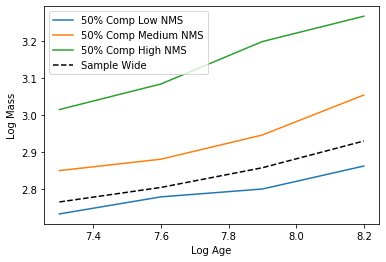

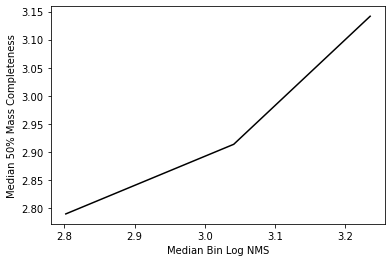

In [643]:
plt.plot(b1_nms_logistic_table['LogAge_Bin_Med'][1:], b1_nms_logistic_table['50%_Comp'][1:], label='50% Comp Low NMS ')
plt.plot(b2_nms_logistic_table['LogAge_Bin_Med'][1:], b2_nms_logistic_table['50%_Comp'][1:], label='50% Comp Medium NMS')
plt.plot(b3_nms_logistic_table['LogAge_Bin_Med'][1:], b3_nms_logistic_table['50%_Comp'][1:], label='50% Comp High NMS')
plt.plot(b3_nms_logistic_table['LogAge_Bin_Med'][1:], sample_wide_50, color='k', linestyle='--', label='Sample Wide')
#plt.plot(b4_nms_logistic_table['LogAge_Bin_Med'], b4_nms_logistic_table['50%_Comp'], label='50% Comp NMS Region 4')
plt.xlabel('Log Age')
plt.ylabel('Log Mass')
plt.legend()
plt.show()

med_50s=[np.median(b1_nms_logistic_table['50%_Comp'][1:]), np.median(b2_nms_logistic_table['50%_Comp'][1:]), np.median(b3_nms_logistic_table['50%_Comp'][1:])]
med_nms=[median_low_nms, median_medium_NMS, median_high_NMS]

plt.plot(np.log10(med_nms), med_50s, color='k')
plt.xlabel('Median Bin Log NMS')
plt.ylabel('Median 50% Mass Completeness')
plt.show()


In [ ]:
#Boostrap sampling with replacement (Highest Priority)
#Find python thing to do this


#What spread did we get and get the 16th, 84th and call this the uncertainty


#Linear interoplation with a grid of these 12 points 

In [644]:
print("B1:", (b1_nms_logistic_table['50%_Comp'][-1]-b1_nms_logistic_table['50%_Comp'][1]))
print("B2:", (b2_nms_logistic_table['50%_Comp'][-1]-b2_nms_logistic_table['50%_Comp'][1]))
print("B3:", (b3_nms_logistic_table['50%_Comp'][-1]-b3_nms_logistic_table['50%_Comp'][1]))
print('Sample Wide:', (sample_wide_50[-1]-sample_wide_50[1]))

B1: 0.1292489713684395
B2: 0.20413034377944905
B3: 0.25195344439378653
Sample Wide: 0.1253590024571456


Text(0.5, 0, 'Log NMS')

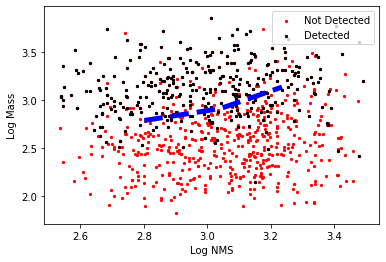

In [630]:
plt.scatter(np.log10(cut_syns['NMS']), np.log10(cut_syns['MASSOUT']), color='r', s=5, label='Not Detected')
plt.scatter(np.log10(cut_syns[np.where(cut_syns['WEIGHTED_DETECTED_.674']==True)]['NMS']), 
            np.log10(cut_syns[np.where(cut_syns['WEIGHTED_DETECTED_.674']==True)]['MASSOUT']), color='k', s=5, label='Detected')
plt.plot(np.log10(med_nms), med_50s, color='b', linestyle='--', linewidth=5)
plt.legend()
plt.ylabel('Log Mass')
plt.xlabel('Log NMS')

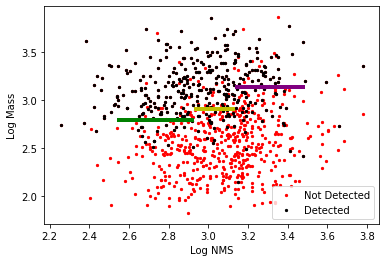

In [691]:
plt.scatter(np.log10(cut_syns1['NMS']), np.log10(cut_syns1['MASSOUT']), color='r', s=5, label='Not Detected')
plt.scatter(np.log10(cut_syns1[np.where(cut_syns1['WEIGHTED_DETECTED_.674']==True)]['NMS']), 
            np.log10(cut_syns1[np.where(cut_syns1['WEIGHTED_DETECTED_.674']==True)]['MASSOUT']), color='k', s=5, label='Detected')
plt.hlines(y=med_50s[0], xmin=min(np.log10(b1_nms['NMS'])), xmax=max(np.log10(b1_nms['NMS'])), color='g',  linewidth=4)
plt.hlines(y=med_50s[1], xmin=min(np.log10(b2_nms['NMS'])), xmax=max(np.log10(b2_nms['NMS'])), color='y',  linewidth=4)
plt.hlines(y=med_50s[2], xmin=min(np.log10(b3_nms['NMS'])), xmax=max(np.log10(b3_nms['NMS'])), color='purple',  linewidth=4)
plt.legend()
plt.ylabel('Log Mass')
plt.xlabel('Log NMS')
plt.show()



Text(0, 0.5, 'Completeness')

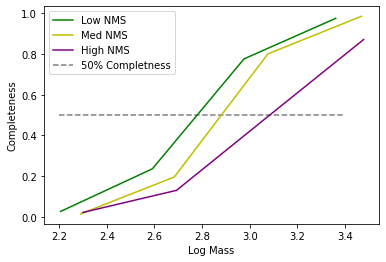

In [632]:
#b1_a1=[b1_nms_logistic_table['LF_Values'][i][0] for i in range(len(b1_nms_logistic_table))]
b1_a1=[b1_nms_logistic_table['LF_Values'][i][1] for i in range(len(b1_nms_logistic_table))]
b1_a2=[b1_nms_logistic_table['LF_Values'][i][2] for i in range(len(b1_nms_logistic_table))]
b1_a3=[b1_nms_logistic_table['LF_Values'][i][3] for i in range(len(b1_nms_logistic_table))]
b1_a4=[b1_nms_logistic_table['LF_Values'][i][4] for i in range(len(b1_nms_logistic_table))]

#b2_a1=[b2_nms_logistic_table['LF_Values'][i][0] for i in range(len(b2_nms_logistic_table))]
b2_a1=[b2_nms_logistic_table['LF_Values'][i][1] for i in range(len(b2_nms_logistic_table))]
b2_a2=[b2_nms_logistic_table['LF_Values'][i][2] for i in range(len(b2_nms_logistic_table))]
b2_a3=[b2_nms_logistic_table['LF_Values'][i][3] for i in range(len(b2_nms_logistic_table))]
b2_a4=[b2_nms_logistic_table['LF_Values'][i][4] for i in range(len(b2_nms_logistic_table))]

#b3_a1=[b3_nms_logistic_table['LF_Values'][i][0] for i in range(len(b3_nms_logistic_table))]
b3_a1=[b3_nms_logistic_table['LF_Values'][i][1] for i in range(len(b3_nms_logistic_table))]
b3_a2=[b3_nms_logistic_table['LF_Values'][i][2] for i in range(len(b3_nms_logistic_table))]
b3_a3=[b3_nms_logistic_table['LF_Values'][i][3] for i in range(len(b3_nms_logistic_table))]
b3_a4=[b3_nms_logistic_table['LF_Values'][i][4] for i in range(len(b3_nms_logistic_table))]

b1_median_lf=[np.median(b1_a1), np.median(b1_a2), np.median(b1_a3), np.median(b1_a4)]              
b2_median_lf=[np.median(b2_a1), np.median(b2_a2), np.median(b2_a3), np.median(b2_a4)]
b3_median_lf=[np.median(b3_a1), np.median(b3_a2), np.median(b3_a3), np.median(b3_a4)]


plt.plot(yedges_1[1:-1], b1_median_lf, color='g', label='Low NMS')
plt.plot(yedges_2[1:-1], b2_median_lf, color='y', label='Med NMS')
plt.plot(yedges_3[1:-1], b3_median_lf, color='purple', label='High NMS')
plt.hlines(y=.5, xmin=2.2, xmax=3.4, color='gray', linestyle='--', label='50% Completness')
plt.legend()
plt.xlabel('Log Mass')
plt.ylabel('Completeness')

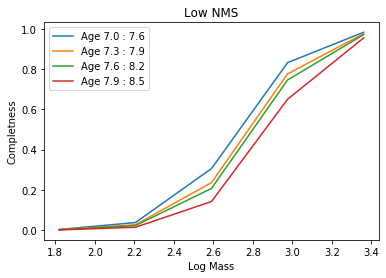

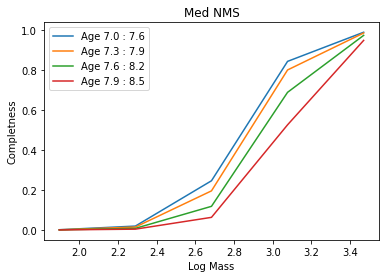

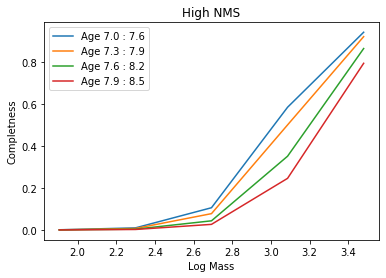

In [646]:
plt.title('Low NMS')
plt.plot(yedges_1[:-1],b1_nms_logistic_table['LF_Values'][1], label='Age 7.0 : 7.6')
plt.plot(yedges_1[:-1],b1_nms_logistic_table['LF_Values'][2], label='Age 7.3 : 7.9')
plt.plot(yedges_1[:-1],b1_nms_logistic_table['LF_Values'][3], label='Age 7.6 : 8.2')
plt.plot(yedges_1[:-1],b1_nms_logistic_table['LF_Values'][4], label='Age 7.9 : 8.5')
plt.legend(loc=2)
plt.xlabel('Log Mass')
plt.ylabel('Completness')
plt.show()

plt.title("Med NMS")
plt.plot(yedges_2[:-1],b2_nms_logistic_table['LF_Values'][1], label='Age 7.0 : 7.6')
plt.plot(yedges_2[:-1],b2_nms_logistic_table['LF_Values'][2], label='Age 7.3 : 7.9')
plt.plot(yedges_2[:-1],b2_nms_logistic_table['LF_Values'][3], label='Age 7.6 : 8.2')
plt.plot(yedges_2[:-1],b2_nms_logistic_table['LF_Values'][4], label='Age 7.9 : 8.5')
plt.legend(loc=2)
plt.xlabel('Log Mass')
plt.ylabel('Completness')
plt.show()

plt.title('High NMS')
plt.plot(yedges_3[:-1],b3_nms_logistic_table['LF_Values'][1], label='Age 7.0 : 7.6')
plt.plot(yedges_3[:-1],b3_nms_logistic_table['LF_Values'][2], label='Age 7.3 : 7.9')
plt.plot(yedges_3[:-1],b3_nms_logistic_table['LF_Values'][3], label='Age 7.6 : 8.2')
plt.plot(yedges_3[:-1],b3_nms_logistic_table['LF_Values'][4], label='Age 7.9 : 8.5')
plt.legend(loc=2)
plt.xlabel('Log Mass')
plt.ylabel('Completness')
plt.show()

Text(0, 0.5, 'Log Mass')

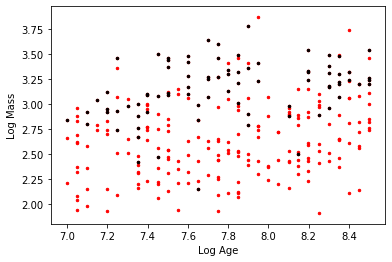

In [634]:
plt.scatter(b3_nms['LOGAGE'], np.log10(b3_nms['MASSOUT']), color='r', s=6)
plt.scatter(b3_nms_D['LOGAGE'], np.log10(b3_nms_D['MASSOUT']), color='k', s=6)
plt.xlabel('Log Age')
plt.ylabel('Log Mass')

In [ ]:
#Get the overal NMS distribution for clusters

#Get the overal NMS distribution for Young Clusters (Using V1 CMD fits)

In [657]:
subimg_data=Table.read('phatm33_subimg-meta.fits')
subimg_data.rename_column('SUBIMG', 'IMG')
subimg_data.rename_column('FILENAME', 'SUBIMG_old')
subimg_data.rename_column('RA', 'IMG_RA')
subimg_data.rename_column('DEC', 'IMG_DEC')

si_lst=list(subimg_data['SUBIMG_old'])
for i in range(len(si_lst)):
    si_lst[i]= si_lst[i].rstrip()
    
new_col=Column(si_lst, name='SUBIMG')
subimg_data.remove_column('SUBIMG_old')
subimg_data.add_column(new_col, index=4)

new_cat=join(cat, subimg_data)
have_nms=new_cat[np.where(new_cat['NMS'] >0)]
have_nms

ID,RA,DEC,"Radius ("")","Effective Eradius ("")",SUBIMG,VIEW_FRAC,CLUSTER_FRAC,GAL_FRAC,EMISSION_FRAC,WEIGHTED_CLUSTER_FRAC,MAG275,SIG275,MAG336,SIG336,MAG475,SIG475,MAG814,SIG814,MAG110,SIG110,MAG160,SIG160,Quick_BestFit_LogAge,Quick_BestFit_LogMass,Quick_BestFit_AV,Quick_BestFit_BG_ScaleFactor,BRICK,FIELD,IMG,TOOTH,IMG_RA,IMG_DEC,RACOORD [4],DECCOORD [4],COVFRAC,NMS,NRGB
int32,float64,float64,float32,float32,str17,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float64,float64,float64,float64,int16,int16,int16,bytes2,float64,float64,float64,float64,float32,int32,int32
1270,23.656689132628667,30.782524600372543,1.2017025,0.27084994,M33-B01-F01-TE_04,0.55737704,0.55737704,0.0,0.0,0.9021559,21.018448,-99.0,21.695751,-99.0,21.337862,0.25257477,20.332403,0.34283853,nan,nan,nan,nan,8.15,3.12977086890536,0.45,0.08865188,1,1,4,TE,23.658274315944844,30.780086212289913,23.664737642325157 .. 23.663337747302773,30.78262665675193 .. 30.775801257788554,0.95448273,360,132
1017,23.662788614568154,30.778000411193673,1.3199118,nan,M33-B01-F01-TE_04,0.5989011,0.5769231,0.0,0.0,0.91279656,19.315552,-99.0,20.778854,0.2253952,nan,nan,nan,nan,nan,nan,nan,nan,7.5,3.0441260941505304,0.75,0.1808787,1,1,4,TE,23.658274315944844,30.780086212289913,23.664737642325157 .. 23.663337747302773,30.78262665675193 .. 30.775801257788554,0.95448273,360,132
1376,23.675132088559508,30.78629410224605,1.2766596,0.90674764,M33-B01-F01-TE_10,0.5081967,0.49180326,0.0,0.0,0.8404337,nan,nan,nan,nan,20.907906,0.08401632,21.110353,-99.0,nan,nan,nan,nan,7.95,2.9333518967982157,0.55,0.06615334,1,1,10,TE,23.680420998574753,30.78801502325342,23.686885443469887 .. 23.68548386077206,30.79055436935382 .. 30.7837292080345,0.44292688,116,44
320,23.68192818920674,30.793699502229558,2.9672515,nan,M33-B01-F01-TE_14,0.88135594,0.81355935,0.033898305,0.033898305,0.9712855,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,7.9,3.638024191636727,1.1,0.4717765,1,1,14,TE,23.681544257906467,30.793486139358087,23.68800910035215 .. 23.686607358133458,30.79602542971639 .. 30.78920028042009,0.5388745,209,59
1027,23.669218381739025,30.804382878590047,1.9235384,0.71685165,M33-B01-F01-TE_23,0.6363636,0.57575756,0.0,0.0,0.69839054,nan,nan,nan,nan,18.620394,0.07205024,18.45885,0.16874519,nan,nan,nan,nan,6.6,2.9542153836504985,0.9,0.1047303,1,1,23,TE,23.67383829855433,30.805935876117168,23.680303774794204 .. 23.678902398076556,30.808475548832156 .. 30.801650316822865,0.3708138,164,49
921,23.66831805974916,30.80608132766136,1.1160959,0.27565572,M33-B01-F01-TE_24,0.5777778,0.562963,0.0,0.0,0.8535577,nan,nan,nan,nan,20.67028,0.043481946,20.327723,0.2615443,nan,nan,nan,nan,-99.0,-99.0,-99.0,-99.0,1,1,24,TE,23.663885124973447,30.807442649267394,23.670350439371884 .. 23.66894974740378,30.809982816016667 .. 30.803157477053865,0.9776414,363,116
862,23.645344466820436,30.8185687395249,1.104536,0.1988436,M33-B01-F01-TN_02,0.6885246,0.6557377,0.032786887,0.032786887,0.92575943,18.743006,0.14485241,20.008692,-99.0,21.522234,0.14010811,19.935343,0.18343495,nan,nan,nan,nan,7.9,3.0719804476623045,0.8,0.03652528,1,1,2,TN,23.649564567159995,30.819349762178526,23.656031061016574 .. 23.65462917997353,30.821889219363413 .. 30.815064034527985,0.98554206,248,113
1311,23.652228440023976,30.826090787656405,1.637834,0.7939355,M33-B01-F01-TN_06,0.5409836,0.5409836,0.0,0.0,0.8915012,nan,nan,nan,nan,21.820011,0.20038328,19.46484,0.31462318,nan,nan,nan,nan,8.7,4.518192558270863,1.95,0.1881617,1,1,6,TN,23.650688065148575,30.824820897304498,23.657154957310706 .. 23.655752916461058,30.827360298796716 .. 30.820535125739937,0.97527725,251,108
1598,23.65416590634765,30.82618482187029,1.328533,0.46388832,M33-B01-F01-TN_06,0.45901638,0.45901638,0.0,0.0,0.75713,nan,nan,nan,nan,21.756699,0.26233926,21.982079,-99.0,nan,nan,nan,nan,8.3,2.9193479796173993,1.05,0.2157118,1,1,6,TN,23.650688065148575,30.824820897304498,23.657154957310706 .. 23.655752916461058,30.8

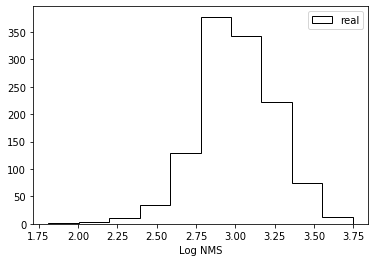

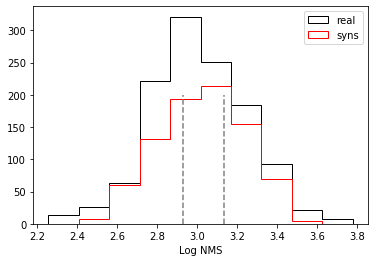

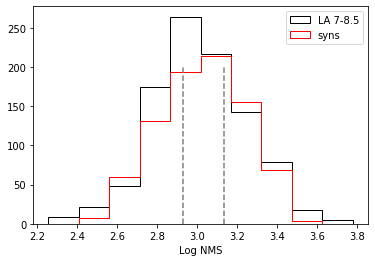

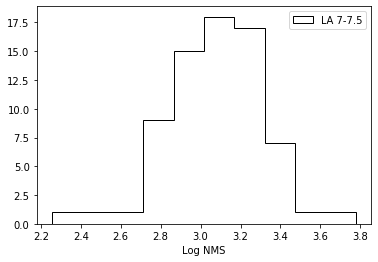

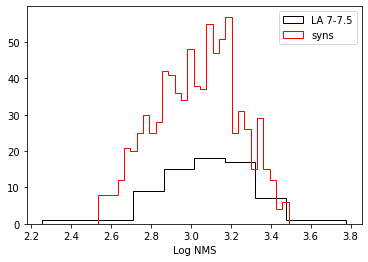

In [690]:
plt.hist(np.log10(have_nms['NMS']), histtype='step', color='k', label='real')
plt.xlabel('Log NMS')
plt.legend()
plt.show()

plt.hist(np.log10(have_nms['NMS']), histtype='step', color='k', bins=b, label='real')
plt.hist(np.log10(cut_syns['NMS']), histtype='step', color='r', bins=b, label='syns')
plt.vlines(x=boundary1, ymin=0, ymax=200, linestyles='--', color='gray')
plt.vlines(x=boundary2, ymin=0, ymax=200, linestyles='--', color='gray')
plt.legend()
plt.xlabel('Log NMS')
plt.show()


same_range=have_nms[np.where((have_nms['Quick_BestFit_LogAge'] > 7.0) & (have_nms['Quick_BestFit_LogAge']< 8.5))]

plt.hist(np.log10(same_range['NMS']), histtype='step', color='k', bins=b, label='LA 7-8.5')
plt.hist(np.log10(cut_syns['NMS']), histtype='step', color='r', bins=b, label='syns')
plt.vlines(x=boundary1, ymin=0, ymax=200, linestyles='--', color='gray')
plt.vlines(x=boundary2, ymin=0, ymax=200, linestyles='--', color='gray')
plt.legend()
plt.xlabel('Log NMS')
plt.show()

yc=have_nms[np.where((have_nms['Quick_BestFit_LogAge'] > 7.0) & (have_nms['Quick_BestFit_LogAge']< 7.5))]

plt.hist(np.log10(yc['NMS']), histtype='step', color='k', bins=b, label='LA 7-7.5')
#plt.hist(np.log10(cut_syns['NMS']), histtype='step', color='r', bins=b, label='syns')
#plt.vlines(x=boundary1, ymin=0, ymax=200, linestyles='--', color='gray')
#plt.vlines(x=boundary2, ymin=0, ymax=200, linestyles='--', color='gray')
plt.legend()
plt.xlabel('Log NMS')
plt.show()

plt.hist(np.log10(yc['NMS']), histtype='step', color='k', bins=b, label='LA 7-7.5')
plt.hist(np.log10(cut_syns['NMS']), histtype='step', color='r', bins=30, label='syns')
#plt.vlines(x=boundary1, ymin=0, ymax=200, linestyles='--', color='gray')
#plt.vlines(x=boundary2, ymin=0, ymax=200, linestyles='--', color='gray')
plt.legend()
plt.xlabel('Log NMS')
plt.show()

Boostrap to try and find the error on the 50% completeness

In [694]:
def Boostrap(bin1, gb_si, D, yedges, k):
    syn_ind=np.where((gb_si['LOGAGE'] >= bin1[0]) & (gb_si['LOGAGE'] < bin1[2]))
    found_ind=np.where((D['LOGAGE'] >= bin1[0]) & (D['LOGAGE'] < bin1[2]))
    clsts=gb_si[syn_ind]
    found=D[found_ind]

    plt.ioff()
    fig1=plt.figure()
    ys,bins,_=plt.hist(np.log10(clsts['MASSIN']), histtype='step', color='r', bins=yedges, label='Total')
    h,x,_=plt.hist(np.log10(found['MASSIN']), histtype='step', color='k', bins=yedges, label='Detected')
    plt.xlabel('Log Mass')
    plt.ylabel('N Synthetic Clusters')
    plt.legend()
    plt.close(fig1)
    
    tot=ys
    com=h/tot

    #Setting error for places with no found to be 1 in error
    where_zeros=np.where(h == 0)
    h[where_zeros] = 1

    err=np.zeros((len(h)))
    for i in range(len(h)):
        err[i]=(sm.stats.proportion.proportion_confint(h[i], tot[i], alpha=.34, method='agresti_coull')[1]-sm.stats.proportion.proportion_confint(h[i], tot[i], alpha=.34, method='agresti_coull')[0])/2

    where_are_NaNs = np.isnan(com)
    where_data = [~np.isnan(com)]

    #Only try and fit bins where I have data
    use_com=com[where_data]
    use_edges=yedges[:-1][where_data]
    use_err=err[where_data]

    initial_guess_f=[np.median(use_edges), k]   
    
    #Up to this point everything has been the same. 
    
    #This is where the Bootstap begins. 
    
    #Each Compleness point is has an error, so I am going to draw a point from within that error bar. 
    #Then refit the Logistic Function 
    
    bs_com=[]
    for i in range(len(use_com)):
        bs_draw=(np.random.normal(0, use_err[i]))
        bs_com.append(use_com[i]+bs_draw)
 
    (fx0_, fk_),_ = opt.curve_fit(forced_slope_gen_logistic_func, xdata=use_edges, ydata=bs_com, sigma=use_err, p0=initial_guess_f, maxfev=500000)
     
    lf_fit_forced_ss=forced_slope_gen_logistic_func(use_edges, x0=fx0_, k=k)    
        
    ptile=[.50]
    ptile_out = np.interp(ptile, fp=use_edges, xp=lf_fit_forced_ss)
    
    hi=completeness(linear_poly1, use_edges, use_com)
    
    return ptile_out

Boostrap(bin_try_1[1], b1_nms, b1_nms_D, yedges_1, k=kb1)

/Users/Tobin/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:31: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
/Users/Tobin/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:32: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
/Users/Tobin/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:33: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, w

array([2.74821336])

In [698]:
import warnings
warnings.filterwarnings("ignore")

In [701]:
round_x=np.zeros((len(xedges_1)))

BS_trials_1=np.zeros((1000, len(round_x)))           
BS_trials_2=np.zeros((1000, len(round_x)))  
BS_trials_3=np.zeros((1000, len(round_x)))  

for i in range(len(BS_trials_1)):
    for j in range(len(round_x)):
        round_x[j]=Boostrap(bin_try_1[j], b1_nms, b1_nms_D, yedges_1, k=kb1)
        BS_trials_1[i]=round_x

for i in range(len(BS_trials_2)):
    for j in range(len(round_x)):
        round_x[j]=Boostrap(bin_try_2[j], b2_nms, b2_nms_D, yedges_2, k=kb2)
        BS_trials_2[i]=round_x   
        
for i in range(len(BS_trials_3)):
    for j in range(len(round_x)):
        round_x[j]=Boostrap(bin_try_3[j], b3_nms, b3_nms_D, yedges_3, k=kb3)
        BS_trials_3[i]=round_x

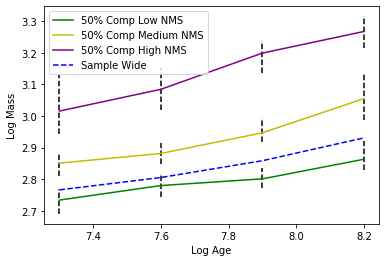

In [710]:
BS_trials_1
b1_p1s=[BS_trials_1[i][1] for i in range(len(BS_trials_1))]
b1_p2s=[BS_trials_1[i][2] for i in range(len(BS_trials_1))]
b1_p3s=[BS_trials_1[i][3] for i in range(len(BS_trials_1))]
b1_p4s=[BS_trials_1[i][4] for i in range(len(BS_trials_1))]

b2_p1s=[BS_trials_2[i][1] for i in range(len(BS_trials_2))]
b2_p2s=[BS_trials_2[i][2] for i in range(len(BS_trials_2))]
b2_p3s=[BS_trials_2[i][3] for i in range(len(BS_trials_2))]
b2_p4s=[BS_trials_2[i][4] for i in range(len(BS_trials_2))]

b3_p1s=[BS_trials_3[i][1] for i in range(len(BS_trials_3))]
b3_p2s=[BS_trials_3[i][2] for i in range(len(BS_trials_3))]
b3_p3s=[BS_trials_3[i][3] for i in range(len(BS_trials_3))]
b3_p4s=[BS_trials_3[i][4] for i in range(len(BS_trials_3))]

b1_p1_16=np.percentile(b1_p1s, 16)
b1_p1_84=np.percentile(b1_p1s, 84)
b1_p2_16=np.percentile(b1_p2s, 16)
b1_p2_84=np.percentile(b1_p2s, 84)
b1_p3_16=np.percentile(b1_p3s, 16)
b1_p3_84=np.percentile(b1_p3s, 84)
b1_p4_16=np.percentile(b1_p4s, 16)
b1_p4_84=np.percentile(b1_p4s, 84)

b2_p1_16=np.percentile(b2_p1s, 16)
b2_p1_84=np.percentile(b2_p1s, 84)
b2_p2_16=np.percentile(b2_p2s, 16)
b2_p2_84=np.percentile(b2_p2s, 84)
b2_p3_16=np.percentile(b2_p3s, 16)
b2_p3_84=np.percentile(b2_p3s, 84)
b2_p4_16=np.percentile(b2_p4s, 16)
b2_p4_84=np.percentile(b2_p4s, 84)

b3_p1_16=np.percentile(b3_p1s, 16)
b3_p1_84=np.percentile(b3_p1s, 84)
b3_p2_16=np.percentile(b3_p2s, 16)
b3_p2_84=np.percentile(b3_p2s, 84)
b3_p3_16=np.percentile(b3_p3s, 16)
b3_p3_84=np.percentile(b3_p3s, 84)
b3_p4_16=np.percentile(b3_p4s, 16)
b3_p4_84=np.percentile(b3_p4s, 84)


plt.plot(b1_nms_logistic_table['LogAge_Bin_Med'][1:], b1_nms_logistic_table['50%_Comp'][1:], color='g', label='50% Comp Low NMS ')
plt.plot(b2_nms_logistic_table['LogAge_Bin_Med'][1:], b2_nms_logistic_table['50%_Comp'][1:], color='y', label='50% Comp Medium NMS')
plt.plot(b3_nms_logistic_table['LogAge_Bin_Med'][1:], b3_nms_logistic_table['50%_Comp'][1:], color='purple', label='50% Comp High NMS')
plt.plot(b3_nms_logistic_table['LogAge_Bin_Med'][1:], sample_wide_50, color='b', linestyle='--', label='Sample Wide')

plt.vlines(x=b1_nms_logistic_table['LogAge_Bin_Med'][1], ymin=b1_p1_16, ymax=b1_p1_84, linestyle='--', color='k')
plt.vlines(x=b1_nms_logistic_table['LogAge_Bin_Med'][2], ymin=b1_p2_16, ymax=b1_p2_84, linestyle='--', color='k')
plt.vlines(x=b1_nms_logistic_table['LogAge_Bin_Med'][3], ymin=b1_p3_16, ymax=b1_p3_84, linestyle='--', color='k')
plt.vlines(x=b1_nms_logistic_table['LogAge_Bin_Med'][4], ymin=b1_p4_16, ymax=b1_p4_84, linestyle='--', color='k')
plt.vlines(x=b2_nms_logistic_table['LogAge_Bin_Med'][1], ymin=b2_p1_16, ymax=b2_p1_84, linestyle='--', color='k')
plt.vlines(x=b2_nms_logistic_table['LogAge_Bin_Med'][2], ymin=b2_p2_16, ymax=b2_p2_84, linestyle='--', color='k')
plt.vlines(x=b2_nms_logistic_table['LogAge_Bin_Med'][3], ymin=b2_p3_16, ymax=b2_p3_84, linestyle='--', color='k')
plt.vlines(x=b2_nms_logistic_table['LogAge_Bin_Med'][4], ymin=b2_p4_16, ymax=b2_p4_84, linestyle='--', color='k')
plt.vlines(x=b3_nms_logistic_table['LogAge_Bin_Med'][1], ymin=b3_p1_16, ymax=b3_p1_84, linestyle='--', color='k')
plt.vlines(x=b3_nms_logistic_table['LogAge_Bin_Med'][2], ymin=b3_p2_16, ymax=b3_p2_84, linestyle='--', color='k')
plt.vlines(x=b3_nms_logistic_table['LogAge_Bin_Med'][3], ymin=b3_p3_16, ymax=b3_p3_84, linestyle='--', color='k')
plt.vlines(x=b3_nms_logistic_table['LogAge_Bin_Med'][4], ymin=b3_p4_16, ymax=b3_p4_84, linestyle='--', color='k')

plt.xlabel('Log Age')
plt.ylabel('Log Mass')
plt.legend()
plt.show()

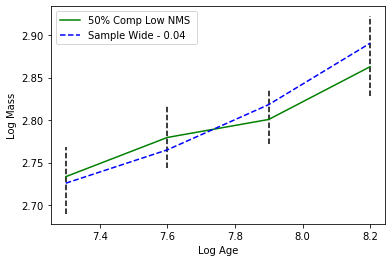

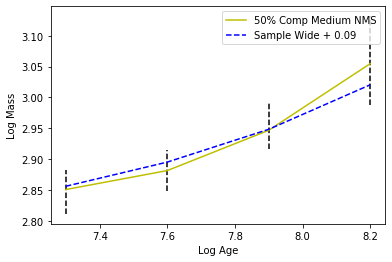

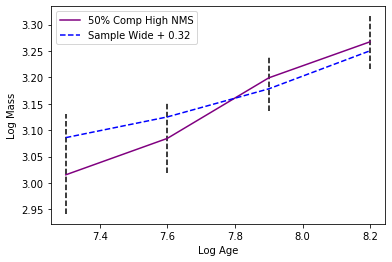

In [720]:
plt.plot(b1_nms_logistic_table['LogAge_Bin_Med'][1:], b1_nms_logistic_table['50%_Comp'][1:], color='g', label='50% Comp Low NMS ')
plt.vlines(x=b1_nms_logistic_table['LogAge_Bin_Med'][1], ymin=b1_p1_16, ymax=b1_p1_84, linestyle='--', color='k')
plt.vlines(x=b1_nms_logistic_table['LogAge_Bin_Med'][2], ymin=b1_p2_16, ymax=b1_p2_84, linestyle='--', color='k')
plt.vlines(x=b1_nms_logistic_table['LogAge_Bin_Med'][3], ymin=b1_p3_16, ymax=b1_p3_84, linestyle='--', color='k')
plt.vlines(x=b1_nms_logistic_table['LogAge_Bin_Med'][4], ymin=b1_p4_16, ymax=b1_p4_84, linestyle='--', color='k')
plt.plot(b3_nms_logistic_table['LogAge_Bin_Med'][1:], sample_wide_50-.04, color='b', linestyle='--', label='Sample Wide - 0.04')
plt.xlabel('Log Age')
plt.ylabel('Log Mass')
plt.legend()
plt.show()


plt.plot(b2_nms_logistic_table['LogAge_Bin_Med'][1:], b2_nms_logistic_table['50%_Comp'][1:], color='y', label='50% Comp Medium NMS')
plt.vlines(x=b2_nms_logistic_table['LogAge_Bin_Med'][1], ymin=b2_p1_16, ymax=b2_p1_84, linestyle='--', color='k')
plt.vlines(x=b2_nms_logistic_table['LogAge_Bin_Med'][2], ymin=b2_p2_16, ymax=b2_p2_84, linestyle='--', color='k')
plt.vlines(x=b2_nms_logistic_table['LogAge_Bin_Med'][3], ymin=b2_p3_16, ymax=b2_p3_84, linestyle='--', color='k')
plt.vlines(x=b2_nms_logistic_table['LogAge_Bin_Med'][4], ymin=b2_p4_16, ymax=b2_p4_84, linestyle='--', color='k')
plt.plot(b3_nms_logistic_table['LogAge_Bin_Med'][1:], sample_wide_50+.09, color='b', linestyle='--', label='Sample Wide + 0.09')
plt.xlabel('Log Age')
plt.ylabel('Log Mass')
plt.legend()
plt.show()


plt.plot(b3_nms_logistic_table['LogAge_Bin_Med'][1:], b3_nms_logistic_table['50%_Comp'][1:], color='purple', label='50% Comp High NMS')
plt.vlines(x=b3_nms_logistic_table['LogAge_Bin_Med'][1], ymin=b3_p1_16, ymax=b3_p1_84, linestyle='--', color='k')
plt.vlines(x=b3_nms_logistic_table['LogAge_Bin_Med'][2], ymin=b3_p2_16, ymax=b3_p2_84, linestyle='--', color='k')
plt.vlines(x=b3_nms_logistic_table['LogAge_Bin_Med'][3], ymin=b3_p3_16, ymax=b3_p3_84, linestyle='--', color='k')
plt.vlines(x=b3_nms_logistic_table['LogAge_Bin_Med'][4], ymin=b3_p4_16, ymax=b3_p4_84, linestyle='--', color='k')
plt.plot(b3_nms_logistic_table['LogAge_Bin_Med'][1:], sample_wide_50+.32, color='b', linestyle='--', label='Sample Wide + 0.32')
plt.xlabel('Log Age')
plt.ylabel('Log Mass')
plt.legend()
plt.show()

In [722]:
b1_errs=[(b1_p1_84-b1_p1_16), (b1_p2_84-b1_p2_16),(b1_p3_84-b1_p1_16),(b1_p4_84-b1_p4_16)]
b2_errs=[(b2_p1_84-b2_p1_16), (b2_p2_84-b2_p2_16),(b2_p3_84-b2_p1_16),(b2_p4_84-b1_p4_16)]
b3_errs=[(b3_p1_84-b3_p1_16), (b3_p2_84-b3_p2_16),(b3_p3_84-b3_p1_16),(b3_p4_84-b1_p4_16)]

In [748]:
b1_nms_logistic_table['LogAge_Bin_Med'][1:]

7.299937438964844
7.599874877929688
7.899812316894531
8.199749755859376


In [759]:
#Formally fit each my exponential and the only thing changing will be “c” 
def nms_exponential(tau, c):
    #fit from completeness limit 
    a=0.06005753215407492
    b=1.0190688706002926
    
    y= a*np.exp(b*(tau-6.71))+c
    return y   


(b1_cf), _ =opt.curve_fit(nms_exponential, xdata=b1_nms_logistic_table['LogAge_Bin_Med'][1:], 
                    ydata=b1_nms_logistic_table['50%_Comp'][1:], sigma=b1_errs, p0=(c_-.04))

(b2_cf), _ =opt.curve_fit(nms_exponential, xdata=b2_nms_logistic_table['LogAge_Bin_Med'][1:], 
                    ydata=b2_nms_logistic_table['50%_Comp'][1:], sigma=b2_errs, p0=(c_+.09))

(b3_cf), _ =opt.curve_fit(nms_exponential, xdata=b3_nms_logistic_table['LogAge_Bin_Med'][1:], 
                    ydata=b3_nms_logistic_table['50%_Comp'][1:], sigma=b2_errs, p0=(c_+.3))
                    
                  
points_to_fit_through=[b1_cf[0], b2_cf[0], b3_cf[0]]                    
                    
def linear_line(x,m, b):
    y= (m*x)+b
    return y

(slope, off),_= opt.curve_fit(linear_line, xdata=np.array(np.log10(med_nms)), ydata=np.array(points_to_fit_through))

slope, off

(0.7117385589429568, 0.6066972150830925)

In [763]:
max(np.log10(cut_syns['NMS']))

3.4899584794248346

In [775]:
min(np.log10(cut_syns['NMS']))

2.537819095073274

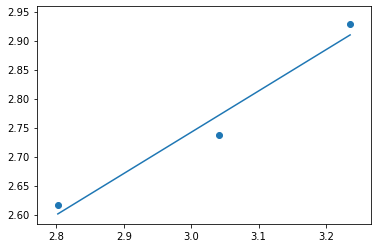

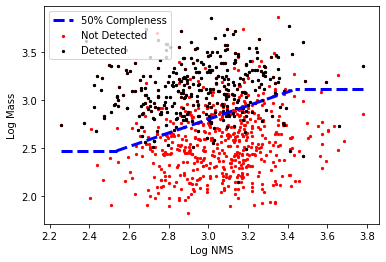

In [780]:
plt.scatter(np.log10(med_nms), points_to_fit_through)
plt.plot(np.log10(med_nms), linear_line(np.log10(med_nms), slope, off))
plt.show()

nms_s=np.arange(start=min(np.log10(cut_syns['NMS'])), stop=max(np.log10(cut_syns['NMS'])), step=.1)

extrapolate_NMS_C=linear_line(nms_s, slope, off)

NMS_compleness=extrapolate_NMS_C+a_

fp=extrapolate_NMS_C[0]
lp=extrapolate_NMS_C[-1]

plt.scatter(np.log10(cut_syns1['NMS']), np.log10(cut_syns1['MASSOUT']), color='r', s=5, label='Not Detected')
plt.scatter(np.log10(cut_syns1[np.where(cut_syns1['WEIGHTED_DETECTED_.674']==True)]['NMS']), 
            np.log10(cut_syns1[np.where(cut_syns1['WEIGHTED_DETECTED_.674']==True)]['MASSOUT']), color='k', s=5, label='Detected')
plt.plot(nms_s, NMS_compleness, linestyle='--', color='b', linewidth=3, label='50% Compleness')
plt.hlines(y=fp+a_, xmin=min(np.log10(cut_syns1['NMS'])), xmax=nms_s[0], linestyle='--',color='b', linewidth=3)
plt.hlines(y=lp+a_, xmin=max(np.log10(cut_syns1['NMS'])), xmax=nms_s[-1], linestyle='--', color='b', linewidth=3)
plt.xlabel('Log NMS')
plt.ylabel('Log Mass')
plt.legend()

In [777]:
lp

3.0535256237171247